In [1]:
%config Completer.use_jedi = False

#!/usr/bin/env python
import sys
import threading
import time

import cv2 as cv
import numpy as np
import rospy
from centermask.config import get_cfg
from detectron2.data import MetadataCatalog
from cv_bridge import CvBridge, CvBridgeError
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2_ros.msg import Result
from sensor_msgs.msg import Image, CompressedImage, RegionOfInterest
import matplotlib.pyplot as plt
import message_filters
import pyrealsense2 as rs2
from sensor_msgs.msg import CameraInfo

import centermask.modeling.backbone

In [2]:
from detectron2_ros.msg import PersonPositions, PersonPosition

In [3]:
def load_param(param, default=None):
    new_param = rospy.get_param(param, default)
    rospy.loginfo("[Centermask2] %s: %s", param, new_param)
    return new_param

def convert_to_cv_image(image_msg):

    if image_msg is None:
        return None

    channels = int(len(image_msg.data) / (image_msg.width * image_msg.height))

    encoding = None
    if image_msg.encoding.lower() in ['rgb8', 'bgr8']:
        encoding = np.uint8
    elif image_msg.encoding.lower() == 'mono8':
        encoding = np.uint8
    elif image_msg.encoding.lower() == '16uc1':
    # For depth images        
        encoding = np.uint16
        channels = 1
    elif image_msg.encoding.lower() == '32fc1':
        encoding = np.float32
        channels = 1

    cv_img = np.ndarray(shape=(image_msg.height, image_msg.width, channels),
                        dtype=encoding, buffer=image_msg.data)

    if image_msg.encoding.lower() == 'mono8':
        cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2GRAY)
    elif image_msg.encoding.lower() == '16uc1':
        pass
    else:
        cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2BGR)

    return cv_img

def convert_compressed_to_cv_image(image_msg):

    # 'msg' as type CompressedImage
    depth_fmt, compr_type = image_msg.format.split(';')
    # remove white space
    depth_fmt = depth_fmt.strip()
    compr_type = compr_type.strip()

    if image_msg is None:
        return None

    encoding = None
    if depth_fmt.lower() in ['rgb8', 'bgr8']:
        encoding = np.uint8
    elif depth_fmt.lower() == 'mono8':
        encoding = np.uint8
    elif depth_fmt.lower() == '16uc1':
    # For depth images        
        encoding = np.uint8
        channels = 1
    elif depth_fmt.lower() == '32fc1':
        encoding = np.float32
        channels = 1

    cv_img = np.frombuffer(image_msg.data, encoding)
    
    if depth_fmt.lower() == '16uc1':
        cv_img = cv.imdecode(cv_img, cv.IMREAD_GRAYSCALE)
    else:
        cv_img = cv.imdecode(cv_img, cv.IMREAD_COLOR)

                             
    if depth_fmt.lower() == 'mono8':
        cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2GRAY)
    elif depth_fmt.lower() == '16uc1':
        pass
    else:
        cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2BGR)

    return cv_img

def getStaticDepthImage(depth_image, predictions, class_names):

    static_depth_img = depth_image.copy()
    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None

    if predictions.has("pred_masks"):
        masks = np.asarray(predictions.pred_masks)
    else:
        return

    class_ids = predictions.pred_classes if predictions.has("pred_classes") else None
    class_names = np.array(class_names)[class_ids.numpy()]
    scores = predictions.scores if predictions.has("scores") else None
    
    arr = (class_names == 'person') & (scores.numpy() > 0.5)
    inds = np.where(arr)[0]
    
    if len(inds)<1:
        return
    
    kernel = np.ones((15,15),np.uint8)
    for i, (x1, y1, x2, y2) in enumerate(boxes[arr]):
#         static_depth_img[masks[inds[i]]]=0
        static_depth_img[(cv.dilate(np.float32(masks[inds[i]]),kernel,iterations = 2)).astype(bool)]=0

    return static_depth_img

def getResult(predictions, header, bridge, class_names):

    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None

    if predictions.has("pred_masks"):
        masks = np.asarray(predictions.pred_masks)
    else:
        return

    class_ids = predictions.pred_classes if predictions.has("pred_classes") else None
    class_names = np.array(class_names)[class_ids.numpy()]
    scores = predictions.scores if predictions.has("scores") else None
    
    arr = (class_names == 'person') & (scores.numpy() > 0.5)
    inds = np.where(arr)[0]
    
    if len(inds)<1:
        return
    
    result_msg = Result()
    result_msg.header = header
    result_msg.class_ids = class_ids[arr]
    result_msg.class_names = class_names[arr]
    result_msg.scores = scores[arr]

#     for i, (x1, y1, x2, y2) in enumerate(boxes):

#     for i in inds:
    for i, (x1, y1, x2, y2) in enumerate(boxes[arr]):
        mask = np.zeros(masks[i].shape, dtype="uint8")
        mask[masks[i, :, :]]=255
        mask = bridge.cv2_to_imgmsg(mask)
        result_msg.masks.append(mask)

        box = RegionOfInterest()
        box.x_offset = np.uint32(x1)
        box.y_offset = np.uint32(y1)
        box.height = np.uint32(y2 - y1)
        box.width = np.uint32(x2 - x1)
        result_msg.boxes.append(box)

    return result_msg

In [4]:
rospy.init_node('centermask2_ros')

bridge = CvBridge()
_last_rgb_msg = None
_last_depth_msg = None
_msg_lock = threading.Lock()
_image_counter = 0

cfg = get_cfg()
# cfg.merge_from_file(load_param('~config'))
# cfg.merge_from_file("/root/centermask2/configs/centermask/centermask_V_99_eSE_FPN_ms_3x.yaml")
cfg.merge_from_file("/root/centermask2/configs/centermask/centermask_lite_V_39_eSE_FPN_ms_4x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = load_param('~detection_threshold') # set threshold for this model
# cfg.MODEL.WEIGHTS = load_param('~model')
# cfg.MODEL.WEIGHTS = "/root/centermask2-V-99-eSE-FPN-ms-3x.pth"
cfg.MODEL.WEIGHTS = "/root/centermask2-lite-V-39-eSE-FPN-ms-4x.pth"
predictor = DefaultPredictor(cfg)
_class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes", None)

_visualization = load_param('~visualization',True)
_result_pub = rospy.Publisher('result', Result, queue_size=1)
_vis_pub = rospy.Publisher('~visualization', Image, queue_size=1)


callback_init = False

def callback_images(rgb_msg, depth_msg):
    rospy.logdebug("Get an image")
    if _msg_lock.acquire(False):
        _last_rgb_msg = rgb_msg
        _last_depth_msg = depth_msg
        _rgb_header = rgb_msg.header
        _depth_header = depth_msg.header
        _msg_lock.release()
    callback_init = True
        
# _sub = rospy.Subscriber(load_param('~input'), Image, callback_image, queue_size=1)
# _image_sub = rospy.Subscriber('/camera/color/image_raw', Image, callback_image, queue_size=1)
# _depth_sub = rospy.Subscriber('/camera/depth/image_rect_raw', Image, callback_image, queue_size=1)

# _image_sub = message_filters.Subscriber('/camera/color/image_raw', CompressedImage)
# _depth_sub = message_filters.Subscriber('/camera/depth/image_rect_raw', CompressedImage)
        
# ts = message_filters.ApproximateTimeSynchronizer([_image_sub, _depth_sub], 1, 0.003)
# ts.registerCallback(callback_images)
  

[INFO] [1630400681.200587]: [Centermask2] ~detection_threshold: None
[INFO] [1630400683.439375]: [Centermask2] ~visualization: True


In [ ]:
_last_rgb_msg_raw = rospy.wait_for_message('/camera/color/image_raw', Image, timeout=None)
_last_depth_msg_raw = rospy.wait_for_message('/camera/aligned_depth_to_color/image_raw', Image, timeout=None)

In [9]:
plt.imshow(convert_to_cv_image(_last_depth_msg_raw))

AttributeError: 'CompressedImage' object has no attribute 'width'

In [5]:
_last_rgb_msg = rospy.wait_for_message('/camera/color/image_raw/compressed', CompressedImage, timeout=None)
_last_depth_msg = rospy.wait_for_message('/camera/depth/image_rect_raw/compressed', CompressedImage, timeout=None)
# _last_compresseddepth_msg = rospy.wait_for_message('/camera/depth/image_rect_raw/compressedDepth', CompressedImage, timeout=None)
# _last_depth_msg = rospy.wait_for_message('/camera/aligned_depth_to_color/image_raw/compressed', CompressedImage, timeout=None)
_rgb_header = _last_rgb_msg.header
_depth_header = _last_depth_msg.header

In [6]:
dur = _last_rgb_msg.header.stamp - _last_depth_msg.header.stamp
dur.to_sec()

-0.06669712100000003

In [10]:
cv_img = np.frombuffer(_last_compresseddepth_msg.data, np.uint16)
# cv_img = cv.imdecode(cv_img, cv.IMREAD_ANYDEPTH)

NameError: name '_last_compresseddepth_msg' is not defined

In [11]:
# 'msg' as type CompressedImage
depth_fmt, compr_type = _last_compresseddepth_msg.format.split(';')
# remove white space
depth_fmt = depth_fmt.strip()
compr_type = compr_type.strip()
if compr_type != "compressedDepth":
    raise Exception("Compression type is not 'compressedDepth'."
                    "You probably subscribed to the wrong topic.")

# remove header from raw data
depth_header_size = 12
raw_data = _last_compresseddepth_msg.data[depth_header_size:]

depth_img_raw = cv.imdecode(np.frombuffer(raw_data, np.uint8), cv.IMREAD_ANYDEPTH)

NameError: name '_last_compresseddepth_msg' is not defined

In [ ]:
plt.imshow(depth_img_raw)

In [ ]:
# For depth images        
encoding = np.uint16
channels = 1

cv_img = np.frombuffer(_last_depth_msg.data, np.uint8)
# cv_img.dtype = np.uint16
# cv_img = cv.imdecode(cv_img, cv.IMREAD_ANYDEPTH)

In [ ]:
# if depth_fmt.lower() == '16uc1':
#     cv_img = cv.imdecode(cv_img, cv.IMREAD_GRAYSCALE)
# else:
#     cv_img = cv.imdecode(cv_img, cv.IMREAD_COLOR)

        
cv_img = np.ndarray(shape=(480, 640, channels),
                    dtype=encoding, buffer=_last_depth_msg.data)

NameError: name '_last_depth_msg_raw' is not defined

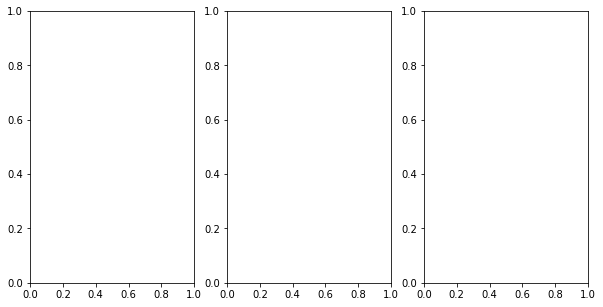

In [7]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.imshow(convert_to_cv_image(_last_depth_msg_raw))
ax1.set_title("Raw")
ax2.imshow(depth_img_raw)
ax2.set_title("CompressedDepth")
ax3.imshow(convert_compressed_to_cv_image(_last_depth_msg))
ax3.set_title("Compressed")

In [ ]:
fig.savefig('depth_compression_comparison')

In [ ]:
from image_transport import SubscriberFilter


In [ ]:
plt.imshow(bridge.compressed_imgmsg_to_cv2(_last_depth_msg))

In [ ]:
help(bridge.compressed_imgmsg_to_cv2)

In [ ]:
msg = rospy.wait_for_message('/depth', Image, timeout=None)
plt.imshow(convert_to_cv_image(msg))

In [ ]:
# 'msg' as type CompressedImage
depth_fmt, compr_type = _last_depth_msg.format.split(';')
# remove white space
depth_fmt = depth_fmt.strip()
compr_type = compr_type.strip()

In [ ]:
depth_fmt

In [ ]:
# cv.imdecode(_last_rgb_msg, cv.CV_LOAD_IMAGE_UNCHANGED)
# convert_to_cv_image(_last_rgb_msg)
#### direct conversion to CV2 ####
cv_img = np.frombuffer(_last_depth_msg.data, np.uint16)
cv_img = cv.imdecode(cv_img, cv.IMREAD_ANYDEPTH)
# cv_img = cv.imdecode(cv_img, cv.IMREAD_COLOR)
# cv_img = cv.imdecode(cv_img, cv.IMREAD_GRAYSCALE)

In [ ]:
cv_img.shape

In [ ]:
# cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2BGR)
# cv_img = cv.cvtColor(cv_img, cv.COLOR_RGB2BGR)


In [ ]:
plt.imshow(cv_img)

In [ ]:
#     rospy.spinOnce()
    
np_image = convert_to_cv_image(_last_rgb_msg)
np_depth_image = convert_to_cv_image(_last_depth_msg)

start_time = time.time()
outputs = predictor(np_image)
finish_time = time.time()
print("Time to predict:" + str(finish_time- start_time))

start_time = time.time()
result = outputs["instances"].to("cpu")
finish_time = time.time()
print("CPU transfer:" + str(finish_time- start_time))

In [ ]:
class_ids = result.pred_classes if result.has("pred_classes") else None
class_names = np.array(_class_names)[class_ids.numpy()]        
# arr = (class_names == 'person') & (scores.numpy() > 0.5)
retain_inds = (result.scores.numpy() > 0.65) & (class_names == 'person')

result = result[retain_inds]

In [ ]:
v = Visualizer(np_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(result)
img = v.get_image()[:, :, ::-1]
image_msg = bridge.cv2_to_imgmsg(img)

plt.imshow(img)

In [ ]:
static_depth_img = getStaticDepthImage(np_depth_image, result, _class_names)

start_time = time.time()
result_msg = getResult(result, _rgb_header, bridge, _class_names)
finish_time = time.time()
print("Results msg time:" + str(finish_time- start_time))

_result_pub.publish(result_msg)

# Visualize resultsresult_msg
start_time = time.time()
v = Visualizer(np_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:, :, ::-1]
image_msg = bridge.cv2_to_imgmsg(img)
finish_time = time.time()
print("Visualisation time:" + str(finish_time- start_time))

plt.imshow(img)
# self._vis_pub.publish(image_msg)

In [ ]:
# Get camera info
rospy.loginfo("Updating camera info")
cameraInfo = rospy.wait_for_message('/camera/color/camera_info', CameraInfo, 60)
P = cameraInfo.P
image_width = cameraInfo.width
image_height = cameraInfo.height

intrinsics = rs2.intrinsics()
intrinsics.width = cameraInfo.width
intrinsics.height = cameraInfo.height
intrinsics.ppx = cameraInfo.K[2]
intrinsics.ppy = cameraInfo.K[5]
intrinsics.fx = cameraInfo.K[0]
intrinsics.fy = cameraInfo.K[4]
intrinsics.model = rs2.distortion.brown_conrady

# Get the pixel location and depth of person centroid
depth_img_copy = np_depth_image.copy()
masks = np.asarray(result.pred_masks)

count = (masks[0] == 1).sum()

y_center, x_center = np.argwhere(masks[0]==True).sum(0)/count

depth = np.median(depth_img_copy[masks[0].astype(bool)])
x_center, y_center, depth

# Convert to 3D position in camera coords 
xyz = rs2.rs2_deproject_pixel_to_point(intrinsics, [x_center, y_center], depth/1000.0)
